In [1]:
# Common imports
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import optuna
from optuna.trial import TrialState

import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [2]:
# Transpose for time-series modeling
train_df = pd.read_csv("train.csv")
submission_df = pd.read_csv("sample_submission.csv")
train_df.set_index("ID", inplace=True)
train_df.columns = pd.to_datetime(train_df.columns, format='%d/%m/%Y')
print(train_df.head())

           2010-04-05  2010-04-06  2010-04-07  2010-04-08  2010-04-09  \
ID                                                                      
company_0        1.30        0.19        0.46       -0.23        1.20   
company_1       -0.83        0.62       -2.74        6.33        1.32   
company_2       -0.02        0.13       -0.70        0.23        1.50   
company_3       -1.10       -0.73       -2.98        1.98        3.00   
company_4        2.23       -1.45       -1.74       -1.13        0.80   

           2010-04-12  2010-04-13  2010-04-14  2010-04-15  2010-04-16  ...  \
ID                                                                     ...   
company_0       -0.26       -0.34        1.64        1.21       -0.85  ...   
company_1        4.52        0.05        3.94        5.01       -3.11  ...   
company_2       -0.23        1.35        2.26        0.37       -3.49  ...   
company_3        1.01        3.60        4.30        1.05       -7.66  ...   
company_4        1.2

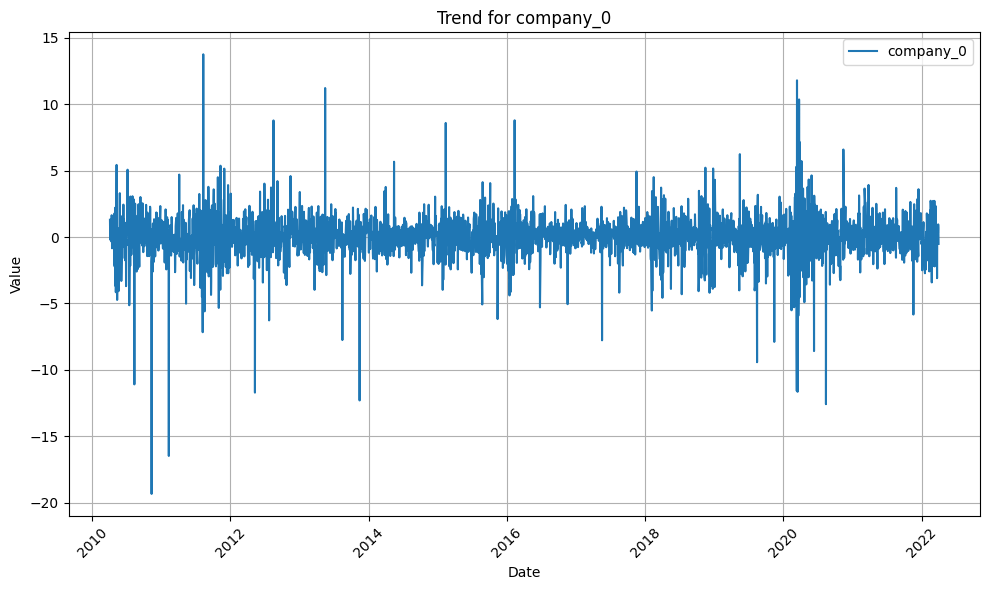

In [3]:
# Choose a company (e.g., company_0)
company = 'company_0'
company_data = train_df.loc[company]

# Plot the time series for the chosen company
plt.figure(figsize=(10, 6))
plt.plot(company_data.index, company_data.values, label=company, color='tab:blue')
plt.title(f"Trend for {company}")
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
# Get last k available days dynamically
k = -90
available_dates = train_df.columns[k:-1]
X = train_df[available_dates].copy()
y = train_df.iloc[:, -1]
y

ID
company_0     -0.52
company_1      1.08
company_2     -1.26
company_3     -0.91
company_4     -4.58
               ... 
company_437   -1.85
company_438   -2.04
company_439   -3.83
company_440   -1.73
company_441   -0.49
Name: 2022-03-31 00:00:00, Length: 442, dtype: float64

In [30]:
def create_features(X):
    X["mean"] = X.mean(axis=1)
    X["std"] = X.std(axis=1)
    X["min"] = X.min(axis=1)
    X["max"] = X.max(axis=1)
    return X

X = create_features(X)
X.head()

,2021-11-22 00:00:00,2021-11-23 00:00:00,2021-11-24 00:00:00,2021-11-26 00:00:00,2021-11-29 00:00:00,2021-11-30 00:00:00,2021-12-01 00:00:00,2021-12-02 00:00:00,2021-12-03 00:00:00,2021-12-06 00:00:00,...,2022-03-23 00:00:00,2022-03-24 00:00:00,2022-03-25 00:00:00,2022-03-28 00:00:00,2022-03-29 00:00:00,2022-03-30 00:00:00,mean,std,min,max
ID,,,,,,,,,,,,,,,,,,,,,
company_0,2.47,1.27,0.43,-1.59,1.95,-1.68,0.35,1.99,0.14,1.28,...,-3.10,0.04,0.86,0.31,0.95,0.68,0.052360,1.544021,-3.42,3.60
company_1,0.80,0.47,0.06,-10.58,0.66,-0.66,-8.19,6.20,-2.54,7.68,...,-1.61,2.92,0.93,1.55,3.96,0.41,-0.087191,4.066194,-17.66,8.42
company_2,-1.62,0.57,-0.32,-2.50,2.12,-3.54,-2.00,2.82,-3.13,0.88,...,-2.06,1.57,0.10,0.90,3.05,-1.24,-0.365056,2.127334,-7.11,3.97
company_3,-2.33,-1.43,1.04,-3.10,1.65,-3.21,-1.38,2.26,-1.77,0.66,...,-4.08,2.09,2.02,2.74,2.33,0.80,-0.184157,2.530714,-8.68,4.91
company_4,-0.10,2.05,0.59,-1.14,-0.18,-1.08,3.32,2.61,-1.25,2.58,...,-2.28,-1.13,-1.53,-0.64,2.32,-1.64,-0.144494,2.041234,-4.63,3.98


In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    """Objective function for Optuna hyperparameter tuning."""
    
    # Hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    num_leaves = trial.suggest_int("num_leaves", 20, 200)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1, log=True)
    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 20, 100)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    subsample = trial.suggest_float("subsample", 0.6, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    lambda_l1 = trial.suggest_float("lambda_l1", 0.0, 10.0)
    lambda_l2 = trial.suggest_float("lambda_l2", 0.0, 10.0)
    min_split_gain = trial.suggest_float("min_split_gain", 0.0, 1.0)
    
    # Model definition
    model = lgb.LGBMRegressor(
        n_estimators=n_estimators,
        num_leaves=num_leaves,
        learning_rate=learning_rate,
        min_data_in_leaf=min_data_in_leaf,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        lambda_l1=lambda_l1,
        lambda_l2=lambda_l2,
        min_split_gain=min_split_gain,
        random_state=42
    )
    
    # Fit the model with early stopping
    model.fit(
        X_train, y_train, 
        eval_set=[(X_valid, y_valid)], 
        verbose=False,
        early_stopping_rounds=50
    )
    
    # Predict on validation data
    preds = model.predict(X_valid)
    
    # Calculate mean squared error
    mse = mean_squared_error(y_valid, preds)
    
    return mse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-03-16 16:43:18,111] A new study created in memory with name: no-name-fb64f9aa-789b-4d7c-a7ef-9ca816ad7cc9
[I 2025-03-16 16:43:18,321] Trial 0 finished with value: 1.4775948325517307 and parameters: {'n_estimators': 418, 'num_leaves': 79, 'learning_rate': 0.0017248169135418005, 'min_data_in_leaf': 60, 'max_depth': 12, 'subsample': 0.9943845913613675, 'colsample_bytree': 0.7766360283175158, 'lambda_l1': 6.491954910241903, 'lambda_l2': 9.66810184568698, 'min_split_gain': 0.670207028575703}. Best is trial 0 with value: 1.4775948325517307.
[I 2025-03-16 16:43:18,405] Trial 1 finished with value: 1.562210651040454 and parameters: {'n_estimators': 252, 'num_leaves': 182, 'learning_rate': 0.0017438059800018461, 'min_data_in_leaf': 77, 'max_depth': 11, 'subsample': 0.8020555920023761, 'colsample_bytree': 0.7329800088677769, 'lambda_l1': 3.4804964196076438, 'lambda_l2': 3.6150266895672423, 'min_split_gain': 0.9813783729008636}. Best is trial 0 with value: 1.4775948325517307.
[I 2025-03-1

In [32]:
# Train final model with best params
best_params = study.best_params
best_model = lgb.LGBMRegressor(**best_params, random_state=42)
best_model.fit(X, y)

LGBMRegressor(colsample_bytree=0.6223927023273654, lambda_l1=3.7868973448898826,
              lambda_l2=7.20027349198704, learning_rate=0.0583673736315855,
              max_depth=14, min_data_in_leaf=65,
              min_split_gain=0.3791357903703856, n_estimators=492,
              num_leaves=102, random_state=42, subsample=0.9022668727014626)

In [33]:
# Predict for submission
predictions = best_model.predict(X)
submission_df["value"] = predictions
submission_df.to_csv("submission.csv", index=False)

print("Submission file saved!")

Submission file saved!
